# Summary

-----

# Imports

In [180]:
%run imports.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2016-09-09 15:36:49.614309


In [181]:
NOTEBOOK_NAME = 'core_data_statistics'
os.environ['NOTEBOOK_NAME'] = NOTEBOOK_NAME

In [182]:
CORE_OR_INTERFACE = 0

# Load data

In [183]:
db_remote = datapkg.MySQLConnection(
    os.environ['DATAPKG_CONNECTION_STRING'], 
    NOTEBOOK_NAME, 
    None, 
    echo=False)

## Load DATA

This includes both calculated (with $\Delta \Delta G$ prediction) and not calculated (without $\Delta \Delta G$ prediction).

In [184]:
with open('load_data/DATA_STANDALONE_CORE.pkl', 'rb') as ifh:
    DATA_STANDALONE = pickle.load(ifh)

In [185]:
for key in DATA_STANDALONE:
    DATA_STANDALONE[key] = kmtools.df_tools.remove_duplicate_columns(DATA_STANDALONE[key])

In [186]:
with open('load_data/DATA_DATABASE_CORE.pkl', 'rb') as ifh:
    DATA_DATABASE = pickle.load(ifh)

In [187]:
for key in DATA_DATABASE:
    DATA_DATABASE[key] = kmtools.df_tools.remove_duplicate_columns(DATA_DATABASE[key])

In [188]:
dataset_map = {
    'protherm': 'protherm++',
    'protherm_star': 'protherm++',
}

DATA = {}
for key in (set(DATA_STANDALONE.keys()) | set(DATA_DATABASE.keys())):
    l = []
    if key in DATA_STANDALONE:
        l.append(DATA_STANDALONE[key])
    if key in DATA_DATABASE:
        l.append(DATA_DATABASE[key])
    DATA[dataset_map.get(key, key)] = pd.concat(l)

## Load DATA_DF

This only includes calculated mutations (with $\Delta \Delta G$ prediction).

In [189]:
DATA_DF = pd.read_pickle('load_data/DATA_DF_CORE.pkl')
#DATA_DF['ddg_exp'] = DATA_DF['ddg_exp'].astype(float)

In [190]:
DATA_DF = kmtools.df_tools.remove_duplicate_columns(DATA_DF)

## Load DATA_DF_TT

In [191]:
DATA_DF_TT = pd.read_pickle('load_data/DATA_DF_TT_CORE.pkl')
#DATA_DF['ddg_exp'] = DATA_DF['ddg_exp'].astype(float)

## Compare

In [192]:
DATA_DATABASE['cosmic'][['uniprot_id', 'uniprot_mutation']].drop_duplicates().shape[0]
# 357,980

357980

In [193]:
DATA_DF[DATA_DF['dataset'] == 'cosmic'][['uniprot_id', 'mutation']].drop_duplicates().shape[0]
# 357,980

357980

In [194]:
pd.concat([
    DATA_DF_TT[DATA_DF_TT['dataset'] == 'cosmic_train'][['uniprot_id', 'mutation']],
    DATA_DF_TT[DATA_DF_TT['dataset'] == 'cosmic_test'][['uniprot_id', 'mutation']]
]).drop_duplicates().shape[0]
# 357,980

331648

# DATA

In [195]:
DATA.keys()

dict_keys(['hiv_escape_mutations', 'taipale', 'benedix_et_al', 'skempi', 'cagi4_sumo_ligase', 'kortemme_baker', 'ab_bind', 'protherm++', 'cosmic', 'humsavar', 'clinvar', 'taipale_ppi', 'taipale_gpca'])

In [196]:
tail_columns = ['humsavar', 'clinvar', 'cosmic', 'cagi4_sumo_ligase']

columns_all = (
    sorted(c for c in DATA.keys() if c not in tail_columns) +
    tail_columns
)
assert not set(DATA.keys()) - set(columns_all)

columns_nodiffseqi = (
    sorted(c for c in DATA.keys() if not c.endswith('_diffseqi') and c not in tail_columns) +
    tail_columns
)

columns_training_set = ['protherm', 'taipale', 'humsavar', 'clinvar', 'cosmic']

## Dataset overlap

In [197]:
counts = {}
df_out = pd.DataFrame(columns=columns_all, index=columns_all, dtype=float)

for dataset_1 in columns_all:
    # print(dataset_1)
    df_1 = DATA[dataset_1].copy()
    # df_1 = df[df['dataset'] == dataset_1]
    mutation_set_1 = set(df_1['uniprot_id'] + '.' + df_1['uniprot_mutation'])
    counts[dataset_1] = len(mutation_set_1)
    for dataset_2 in columns_all:
        # print('\t', dataset_2)
        df_2 = DATA[dataset_2].copy()
        # df_2 = df[df['dataset'] == dataset_2]
        mutation_set_2 = set(df_2['uniprot_id'] + '.' + df_2['uniprot_mutation'])
        frac_covered = 1 - len(mutation_set_1 - mutation_set_2) / len(mutation_set_1)
        df_out.loc[dataset_1, dataset_2] = frac_covered * 100.0
df_out.index = ['{}\n(n = {:.0f})'.format(x, counts[x]) for x in df_out.index]

(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5,  12.5]), <a list of 13 Text xticklabel objects>)

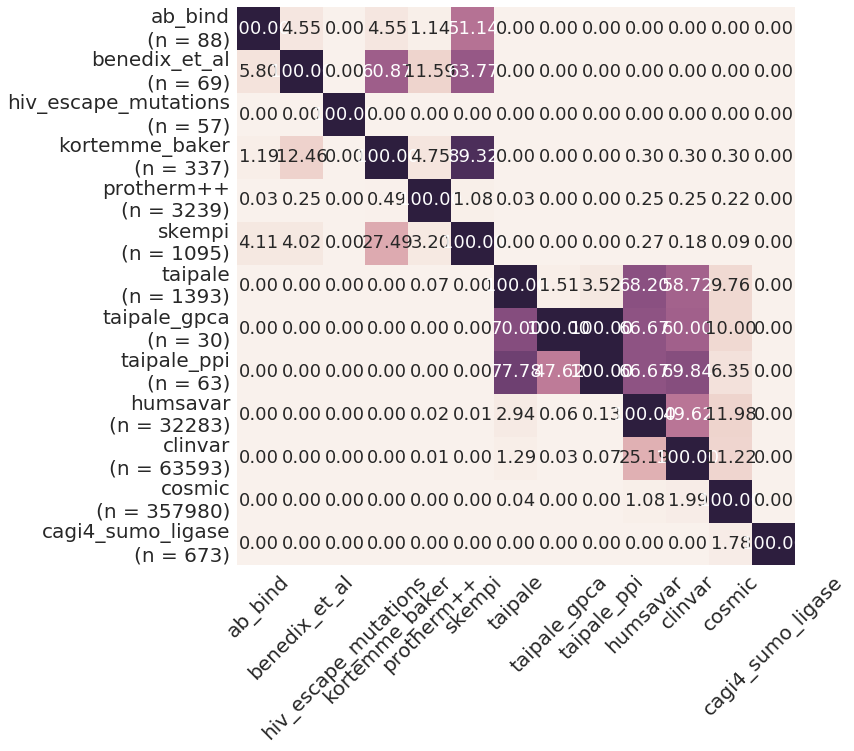

In [198]:
fg, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(df_out, annot=True, fmt=".2f", ax=ax, square=True, cbar=False, annot_kws={"size": 18})
plt.yticks(rotation='horizontal')
plt.xticks(rotation=45)

## Correlations

/home/kimlab1/strokach/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


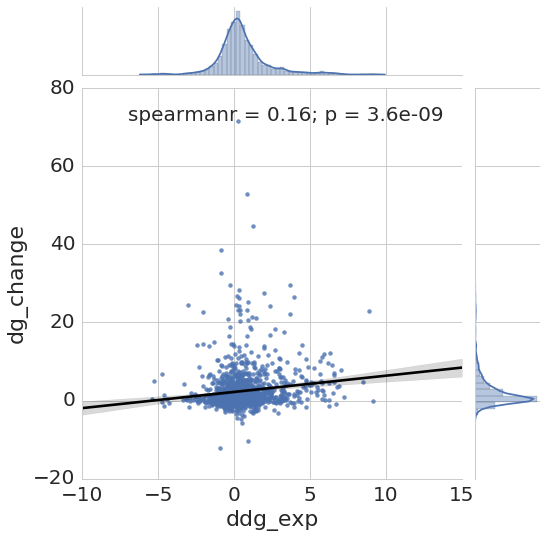

In [199]:
# Some validation to make sure that we 
ax = sns.jointplot(
    x='ddg_exp', 
    y='dg_change',
    data=DATA['taipale'][['ddg_exp', 'dg_change']].drop_duplicates(), 
    stat_func=sp.stats.spearmanr,
    kind="reg",
    size=8,
    line_kws={'color': 'k'},
)

### Correlation with Foldx

ab_bind
benedix_et_al
hiv_escape_mutations
kortemme_baker
protherm++
skempi
taipale
taipale_gpca
taipale_ppi
humsavar
clinvar
cosmic
cagi4_sumo_ligase


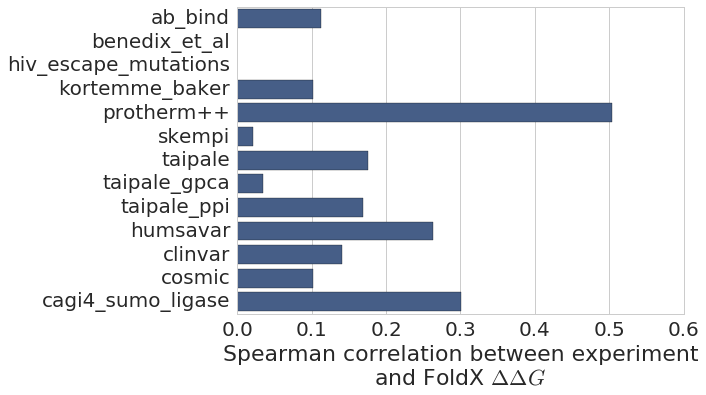

In [200]:
corrs = OrderedDict()
for table_name in columns_nodiffseqi:
    print(table_name)
    df = DATA[table_name].drop_duplicates()
    if table_name in ['humsavar', 'clinvar', 'cosmic']:
        df['ddg_exp'] = df['del_class_exp']
    elif table_name in ['cagi4_sumo_ligase']:
        df['ddg_exp'] = -df['del_score_exp']
    df = df.dropna(subset=['dg_change', 'ddg_exp'])
    corrs[table_name] = sp.stats.spearmanr(df['dg_change'], df['ddg_exp'])[0]
corrs = pd.Series(corrs)

fg, ax = plt.subplots()
x = sns.barplot(corrs.values, corrs.index, ax=ax, color=sns.xkcd_rgb["denim blue"])
plt.xlim(0, 0.6)
ax.set_xlabel('Spearman correlation between experiment\nand FoldX $\Delta \Delta G$')

### Correlation with Provean

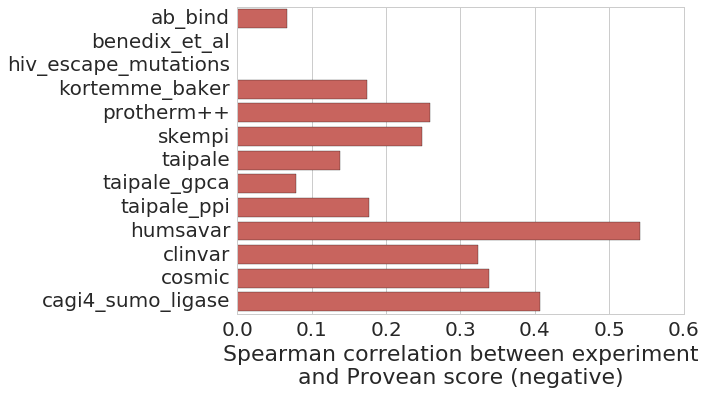

In [201]:
corrs = OrderedDict()
for table_name in columns_nodiffseqi:
    df = DATA[table_name].drop_duplicates()
    if table_name in ['humsavar', 'clinvar', 'cosmic']:
        df['ddg_exp'] = df['del_class_exp']
    elif table_name in ['cagi4_sumo_ligase']:
        df['ddg_exp'] = -df['del_score_exp']
    df = df.dropna(subset=['provean_score', 'ddg_exp'])
    corrs[table_name] = -sp.stats.spearmanr(df['provean_score'], df['ddg_exp'])[0]
corrs = pd.Series(corrs)

fg, ax = plt.subplots()
x = sns.barplot(corrs.values, corrs.index, ax=ax, color=sns.xkcd_rgb["pale red"])
plt.xlim(0, 0.6)
ax.set_xlabel('Spearman correlation between experiment\nand Provean score (negative)')

# DATA_DF

In [202]:
DATA_DF.head()

,_index,alignment_coverage,alignment_def,alignment_filename,alignment_identity,alignment_score,alignment_subdefs,analyse_complex_energy_mut,analyse_complex_energy_wt,backbone_clash_change,backbone_clash_wt,backbone_hbond_change,backbone_hbond_wt,cath_id,chain,chain_modeller,cis_bond_change,cis_bond_wt,contact_distance_change,contact_distance_wt,dataset,db,ddg,ddg_exp,ddg_exp_pstar,del_class_exp,del_score_exp,dg_change,dg_wt,disulfide_change,disulfide_wt,domain_def,domain_end,domain_start,electrostatic_kon_change,electrostatic_kon_wt,electrostatics_change,electrostatics_wt,energy_ionisation_change,energy_ionisation_wt,entropy_complex_change,entropy_complex_wt,entropy_mainchain_change,entropy_mainchain_wt,entropy_sidechain_change,entropy_sidechain_wt,gene_name,helix_dipole_change,helix_dipole_wt,id,idx,idxs,interface_area_hydrophilic,interface_area_hydrophobic,interface_area_total,m_date_modified,matrix_score,max_seq_identity,mloop_entropy_change,mloop_entropy_wt,model_domain_def,model_errors,model_file_mut,model_file_wt,model_filename,model_filename_mut,model_filename_wt,mut_date_modified,mutation,mutation_errors,mutation_in_interface,mutation_modeller,norm_dope,number_of_residues,organism_name,partial_covalent_bonds_change,partial_covalent_bonds_wt,partner_pdb_chain,partner_uniprot_id,path_to_data,pcv_hbond_change,pcv_hbond_self_change,pcv_hbond_self_wt,pcv_hbond_wt,pcv_salt_equal_change,pcv_salt_equal_self_change,pcv_salt_equal_self_wt,pcv_salt_equal_wt,pcv_salt_opposite_change,pcv_salt_opposite_self_change,pcv_salt_opposite_self_wt,pcv_salt_opposite_wt,pcv_vdw_change,pcv_vdw_self_change,pcv_vdw_self_wt,pcv_vdw_wt,pdb_chain,pdb_id,pdb_mutation,pdbfam_idx,pdbfam_name,pfam_clan,pfam_id,pfam_names,protein_existence,protein_name,provean_score,sasa_score,secondary_structure_change,secondary_structure_wt,sequence_version,sidechain_hbond_change,sidechain_hbond_wt,sloop_entropy_change,sloop_entropy_wt,solvation_hydrophobic_change,solvation_hydrophobic_wt,solvation_polar_change,solvation_polar_wt,solvent_accessibility_change,solvent_accessibility_wt,t_date_modified,template_errors,torsional_clash_change,torsional_clash_wt,uniprot_domain_id,uniprot_domain_id_old,uniprot_id,uniprot_mutation,uniprot_name,uniprot_sequence,van_der_waals_change,van_der_waals_clashes_change,van_der_waals_clashes_wt,van_der_waals_wt,water_bridge_change,water_bridge_wt
0,1.0,1.0,NaN,NaN,1.0,1.0,NaN,None,None,-0.244,195.481,0.314,-143.661,NaN,NaN,A,0.0,0.0,NaN,NaN,skempi++,NaN,2.657027,0.1,NaN,NaN,NaN,2.65230,2.01672,0.0,-4.67814,NaN,NaN,NaN,0.0,0.0,0.12582,-5.77961,-0.024015,0.340410,0.0,0.0,-0.304,262.272,-1.427,124.739,NaN,0.00000,-3.58583,NaN,0.0,None,NaN,NaN,NaN,NaT,-1.0,100.0,0.0,0.0,NaN,NaN,/home/kimlab1/database_data/biodb/recipes/elas...,/home/kimlab1/database_data/biodb/recipes/elas...,NaN,NaN,NaN,NaT,M14A,,NaN,M14A,-1.560773,180.0,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-19.0,49.0,0.0,A,1a22,A_M14A,NaN,NaN,NaN,PF00103,NaN,NaN,NaN,-3.109,NaN,0,4.0,NaN,0.0000,-54.0679,0.0,0.0,3.277,-286.457,-1.317,280.986,3.937140,9.826732,NaT,NaN,-0.0530,18.4501,NaN,NaN,P01241,M40A,NaN,NaN,2.071,-0.0093,28.6383,-215.180,0.0,0.0
1,2.0,1.0,NaN,NaN,1.0,1.0,NaN,None,None,-0.224,195.478,1.006,-143.619,NaN,NaN,A,0.0,0.0,NaN,NaN,skempi++,NaN,1.060820,-0.5,NaN,NaN,NaN,0.63746,2.58498,0.0,-4.67814,NaN,NaN,NaN,0.0,0.0,0.77509,-5.66908,-0.253182,0.316395,0.0,0.0,-0.509,262.266,-0.964,124.288,NaN,-0.01874,-3.58582,NaN,0.0,None,NaN,NaN,NaN,NaT,-2.0,100.0,0.0,0.0,NaN,NaN,/home/kimlab1/database_data/biodb/recipes/elas...,/home/kimlab1/database_data/biodb/recipes/elas...,NaN,NaN,NaN,NaT,H18A,,NaN,H18A,-1.560773,180.0,NaN,0.0,0.0,NaN,NaN,NaN,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-10.0,29.0,0.0,A,1a22,A_H18A,NaN,NaN,NaN,PF00103,NaN,NaN,NaN,-4.746,NaN,0,4.0,NaN,0.8790,-52.8357,0.0,0.0,0.949,-286.460,-2.146,280.572,-1.582074,44.123250,NaT,NaN,-0.0038,18.4395,NaN,NaN,P01241,H44A,NaN,NaN,0.932,-0.0070,28.6946,-215.144,0.0,0.0
2,3.0,1.0,NaN

In [203]:
DATA_DF['dataset'].drop_duplicates().tolist()

['skempi++',
 'protherm++',
 'hiv_escape_mutations',
 'benedix_et_al',
 'ab_bind',
 'clinvar',
 'humsavar',
 'taipale_gpca',
 'taipale_ppi',
 'taipale',
 'cagi4_sumo_ligase',
 'cosmic']

In [204]:
datasets = [
    'protherm++',
    'taipale',
    'humsavar',
    'clinvar',
    'cosmic',
    'cagi4_sumo_ligase'
]

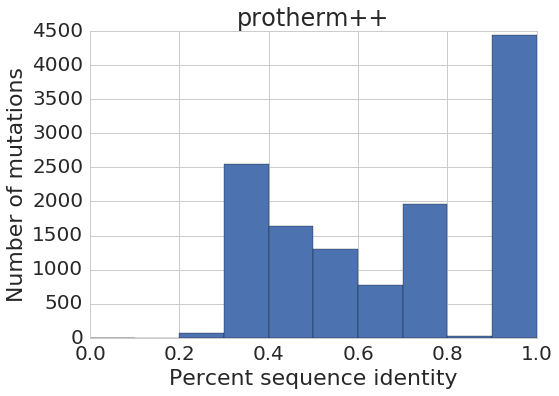

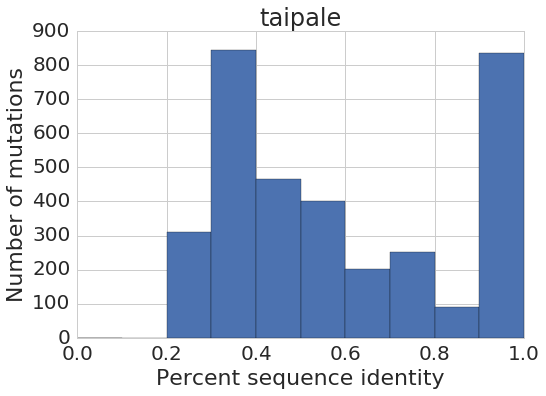

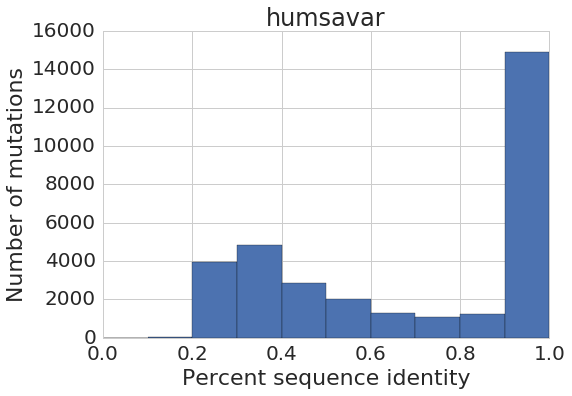

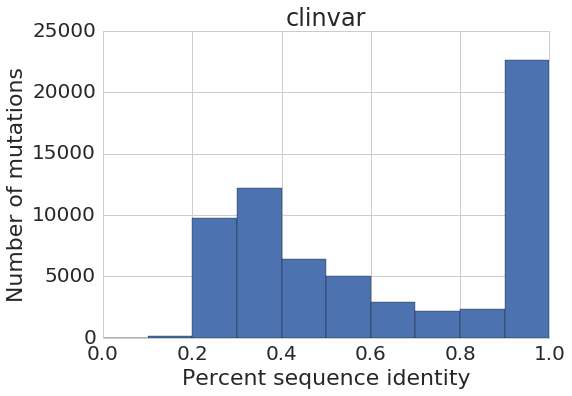

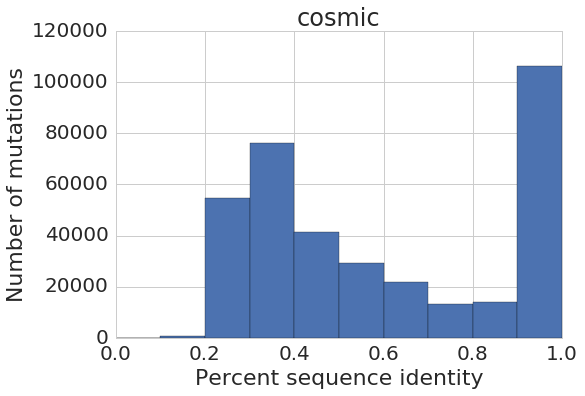

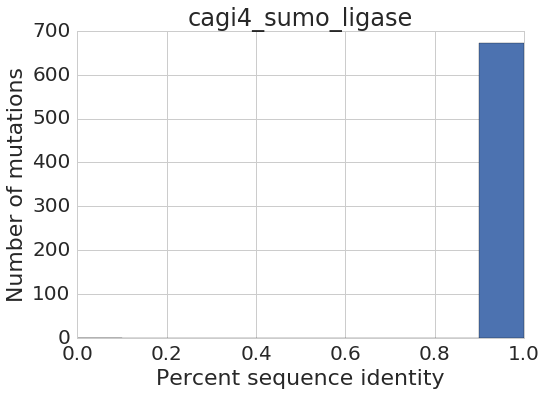

In [205]:
# Histogram sequence identities
for dataset in datasets:
    plt.figure()
    DATA_DF[DATA_DF['dataset'] == dataset]['alignment_identity'].hist(range=(0, 1), bins=10)
    plt.title(dataset)
    plt.xlabel("Percent sequence identity")
    plt.ylabel("Number of mutations")

## Dataset overlap

In [206]:
datasets = [
    'protherm++',
    'taipale',
    'humsavar',
    'clinvar',
    'cosmic',
    'cagi4_sumo_ligase',
]

assert not set(DATA_DF['dataset']) ^ set(datasets)

AssertionError: 

In [ ]:
counts = {}
df = DATA_DF.dropna(subset=['ddg']).copy()
df_out = pd.DataFrame(columns=datasets, index=datasets, dtype=float)
for dataset_1 in datasets:
    print(dataset_1)
    df_1 = df[df['dataset'] == dataset_1]
    mutation_set_1 = set(df_1['uniprot_id'] + '.' + df_1['uniprot_mutation'])
    counts[dataset_1] = len(mutation_set_1)
    for dataset_2 in datasets:
        # print('\t', dataset_2)
        df_2 = df[df['dataset'] == dataset_2]
        mutation_set_2 = set(df_2['uniprot_id'] + '.' + df_2['uniprot_mutation'])
        frac_covered = 1 - len(mutation_set_1 - mutation_set_2) / len(mutation_set_1)
        df_out.loc[dataset_1, dataset_2] = frac_covered * 100.0
df_out.index = ['{}\n(n = {:.0f})'.format(x, counts[x]) for x in df_out.index]

In [ ]:
fg, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(df_out, annot=True, fmt=".2f", ax=ax, square=True, cbar=False, annot_kws={"size": 18})
plt.yticks(rotation='horizontal')
plt.savefig(op.join(NOTEBOOK_NAME, 'training_set_overlap_final.png'), bbox_inches='tight', dpi=220)
plt.savefig(op.join(NOTEBOOK_NAME, 'training_set_overlap_final.pdf'), bbox_inches='tight')

## Correlations

### Correlation with FoldX

In [ ]:
corrs = OrderedDict()
for table_name in datasets:
    df = DATA_DF[DATA_DF['dataset'] == table_name].drop_duplicates().copy()
    if table_name in ['humsavar', 'clinvar', 'cosmic']:
        df['ddg_exp'] = df['del_class_exp']
    if table_name in ['cagi4_sumo_ligase']:
        df['ddg_exp'] = -df['del_score_exp']
    df = df.dropna(subset=['dg_change', 'ddg_exp'])
    corrs[table_name] = sp.stats.spearmanr(df['dg_change'], df['ddg_exp'])[0]
corrs = pd.Series(corrs)

fg, ax = plt.subplots()
x = sns.barplot(corrs.values, corrs.index, ax=ax, color=sns.xkcd_rgb["denim blue"])
plt.xlim(0, 0.6)
ax.set_xlabel('Spearman correlation between experiment\nand FoldX $\Delta \Delta G$')
# plt.savefig(op.join(NOTEBOOK_NAME, 'foldx_correlation_final.png'), bbox_inches='tight', dpi=220)
# plt.savefig(op.join(NOTEBOOK_NAME, 'foldx_correlation_final.pdf'), bbox_inches='tight')

### Correlation with Provean

In [ ]:
corrs = OrderedDict()
for table_name in datasets:
    df = DATA_DF[DATA_DF['dataset'] == table_name].drop_duplicates()
    if table_name in ['humsavar', 'clinvar', 'cosmic']:
        df['ddg_exp'] = df['del_class_exp']
    elif table_name in ['cagi4_sumo_ligase']:
        df['ddg_exp'] = -df['del_score_exp']
    df = df.dropna(subset=['provean_score', 'ddg_exp'])
    corrs[table_name] = -sp.stats.spearmanr(df['provean_score'], df['ddg_exp'])[0]
corrs = pd.Series(corrs)

fg, ax = plt.subplots()
x = sns.barplot(corrs.values, corrs.index, ax=ax, color=sns.xkcd_rgb["pale red"])
plt.xlim(0, 0.6)
ax.set_xlabel('Spearman correlation between experiment\nand Provean score (negative)')
# plt.savefig(op.join(NOTEBOOK_NAME, 'provean_correlation_final.png'), bbox_inches='tight', dpi=220)
# plt.savefig(op.join(NOTEBOOK_NAME, 'provean_correlation_final.pdf'), bbox_inches='tight')

# DATA_DF_TT

## Dataset overlap

In [ ]:
datasets = [
    'protherm++',
    'taipale',
    'humsavar_train',
    'clinvar_train',
    'cosmic_train',
    'humsavar_test',
    'clinvar_test',
    'cosmic_test',
    'cagi4_sumo_ligase',
]

assert not set(DATA_DF_TT['dataset']) ^ set(datasets)

In [ ]:
counts = {}
df = DATA_DF_TT.dropna(subset=['ddg']).copy()
df_out = pd.DataFrame(columns=datasets, index=datasets, dtype=float)
for dataset_1 in datasets:
    print(dataset_1)
    df_1 = df[df['dataset'] == dataset_1]
    mutation_set_1 = set(df_1['uniprot_id'] + '.' + df_1['uniprot_mutation'])
    counts[dataset_1] = len(mutation_set_1)
    for dataset_2 in datasets:
        # print('\t', dataset_2)
        df_2 = df[df['dataset'] == dataset_2]
        mutation_set_2 = set(df_2['uniprot_id'] + '.' + df_2['uniprot_mutation'])
        frac_covered = 1 - len(mutation_set_1 - mutation_set_2) / len(mutation_set_1)
        df_out.loc[dataset_1, dataset_2] = frac_covered * 100.0
df_out.index = ['{}\n(n = {:,.0f})'.format(x, counts[x]) for x in df_out.index]

In [ ]:
fg, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(df_out, annot=True, fmt=".2f", ax=ax, square=True, cbar=False, annot_kws={"size": 18})
plt.yticks(rotation='horizontal')
# plt.savefig(op.join(NOTEBOOK_NAME, 'training_set_overlap_final.png'), bbox_inches='tight', dpi=220)
# plt.savefig(op.join(NOTEBOOK_NAME, 'training_set_overlap_final.pdf'), bbox_inches='tight')

## Correlations

### Correlation with FoldX

In [ ]:
corrs = OrderedDict()
for table_name in datasets:
    df = DATA_DF_TT[DATA_DF_TT['dataset'] == table_name].drop_duplicates().copy()
    if table_name in ['humsavar', 'clinvar', 'cosmic']:
        df['ddg_exp'] = df['del_class_exp']
    if table_name in ['cagi4_sumo_ligase']:
        df['ddg_exp'] = -df['del_score_exp']
    df = df.dropna(subset=['dg_change', 'ddg_exp'])
    corrs[table_name] = sp.stats.spearmanr(df['dg_change'], df['ddg_exp'])[0]
corrs = pd.Series(corrs)

fg, ax = plt.subplots()
x = sns.barplot(corrs.values, corrs.index, ax=ax, color=sns.xkcd_rgb["denim blue"])
plt.xlim(0, 0.6)
ax.set_xlabel('Spearman correlation between experiment\nand FoldX $\Delta \Delta G$')
# plt.savefig(op.join(NOTEBOOK_NAME, 'foldx_correlation_final.png'), bbox_inches='tight', dpi=220)
# plt.savefig(op.join(NOTEBOOK_NAME, 'foldx_correlation_final.pdf'), bbox_inches='tight')

### Correlation with Provean

In [ ]:
corrs = OrderedDict()
for table_name in datasets:
    df = DATA_DF_TT[DATA_DF_TT['dataset'] == table_name].drop_duplicates()
    if table_name in ['humsavar', 'clinvar', 'cosmic']:
        df['ddg_exp'] = df['del_class_exp']
    elif table_name in ['cagi4_sumo_ligase']:
        df['ddg_exp'] = -df['del_score_exp']
    df = df.dropna(subset=['provean_score', 'ddg_exp'])
    corrs[table_name] = -sp.stats.spearmanr(df['provean_score'], df['ddg_exp'])[0]
corrs = pd.Series(corrs)

fg, ax = plt.subplots()
x = sns.barplot(corrs.values, corrs.index, ax=ax, color=sns.xkcd_rgb["pale red"])
plt.xlim(0, 0.6)
ax.set_xlabel('Spearman correlation between experiment\nand Provean score (negative)')
# plt.savefig(op.join(NOTEBOOK_NAME, 'provean_correlation_final.png'), bbox_inches='tight', dpi=220)
# plt.savefig(op.join(NOTEBOOK_NAME, 'provean_correlation_final.pdf'), bbox_inches='tight')

In [ ]:
train_datasets = [
    'protherm++', 'taipale', 'humsavar_train', 'clinvar_train', 'cosmic_train', 'cagi4_sumo_ligase'
]

In [ ]:
# Compare ELASPIC and FoldX on the test set (NO ABS)
fg, axes = plt.subplots(1, 6, figsize=(16, 4))
axes[0].set_ylabel('Spearman R')
for i, train_dataset in enumerate(train_datasets):
    ax = axes[i]
    # print(train_dataset)
    if train_dataset in ['protherm++', 'taipale']:
        df = (
            DATA_DF_TT[DATA_DF_TT['dataset'] == train_dataset]
            [['dg_change', 'ddg_exp', 'provean_score']]
            .dropna()
        )
        foldx_r = sp.stats.spearmanr(df['dg_change'], df['ddg_exp'])[0]
        provean_r = sp.stats.spearmanr(df['provean_score'], df['ddg_exp'])[0] * -1
    elif train_dataset in ['cagi4_sumo_ligase']:
        df = (
            DATA_DF_TT[DATA_DF_TT['dataset'] == train_dataset]
            [['dg_change', 'del_score_exp', 'provean_score']]
            .dropna()
        )
        foldx_r = sp.stats.spearmanr(df['dg_change'], -df['del_score_exp'])[0]
        provean_r = sp.stats.spearmanr(df['provean_score'], -df['del_score_exp'])[0] * -1
    else:
        df = (
            DATA_DF_TT[DATA_DF_TT['dataset'] == train_dataset]
            [['dg_change', 'del_class_exp', 'provean_score']]
            .dropna()
        )
        foldx_r = sp.stats.spearmanr(df['dg_change'], df['del_class_exp'])[0]
        provean_r = sp.stats.spearmanr(df['provean_score'], df['del_class_exp'])[0] * -1
    ax.bar(
        [1, 2], 
        [abs(foldx_r), abs(provean_r)],
        tick_label=['FoldX', 'Provean'], 
        align='center', 
        color=[sns.palettes.color_palette()[0], 
               sns.palettes.color_palette()[4]])
    ax.set_ylim(0, 0.60)
    ax.set_title(train_dataset)
    ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=45)
    # print(elaspic_r, foldx_r)

plt.tight_layout()

# plt.savefig(op.join(NOTEBOOK_NAME, 'initial_performance.png'), bbox_inches='tight', dpi=220)
# plt.savefig(op.join(NOTEBOOK_NAME, 'initial_performance.pdf'), bbox_inches='tight')

In [ ]:
test_datasets = [
    'protherm++', 'taipale', 'humsavar_test', 'clinvar_test', 'cosmic_test', 'cagi4_sumo_ligase'
]

In [ ]:
# Compare ELASPIC and FoldX on the test set (NO ABS)
fg, axes = plt.subplots(1, 6, figsize=(16, 4))
axes[0].set_ylabel('Spearman R')
for i, test_dataset in enumerate(test_datasets):
    ax = axes[i]
    # print(test_dataset)
    if test_dataset in ['protherm++', 'taipale']:
        df = (
            DATA_DF_TT[DATA_DF_TT['dataset'] == test_dataset]
            [['dg_change', 'ddg_exp', 'provean_score']]
            .dropna()
        )
        foldx_r = sp.stats.spearmanr(df['dg_change'], df['ddg_exp'])[0]
        provean_r = sp.stats.spearmanr(df['provean_score'], df['ddg_exp'])[0] * -1
    elif test_dataset in ['cagi4_sumo_ligase']:
        df = (
            DATA_DF_TT[DATA_DF_TT['dataset'] == test_dataset]
            [['dg_change', 'del_score_exp', 'provean_score']]
            .dropna()
        )
        foldx_r = sp.stats.spearmanr(df['dg_change'], -df['del_score_exp'])[0]
        provean_r = sp.stats.spearmanr(df['provean_score'], -df['del_score_exp'])[0] * -1
    else:
        df = (
            DATA_DF_TT[DATA_DF_TT['dataset'] == test_dataset]
            [['dg_change', 'del_class_exp', 'provean_score']]
            .dropna()
        )
        foldx_r = sp.stats.spearmanr(df['dg_change'], df['del_class_exp'])[0]
        provean_r = sp.stats.spearmanr(df['provean_score'], df['del_class_exp'])[0] * -1
    ax.bar(
        [1, 2], 
        [abs(foldx_r), abs(provean_r)],
        tick_label=['FoldX', 'Provean'], 
        align='center', 
        color=[sns.palettes.color_palette()[0], 
               sns.palettes.color_palette()[4]])
    ax.set_ylim(0, 0.60)
    ax.set_title(test_dataset)
    ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=45)
    # print(elaspic_r, foldx_r)

plt.tight_layout()

# plt.savefig(op.join(NOTEBOOK_NAME, 'initial_performance.png'), bbox_inches='tight', dpi=220)
# plt.savefig(op.join(NOTEBOOK_NAME, 'initial_performance.pdf'), bbox_inches='tight')

In [ ]:
Counter(DATA_DF_TT['dataset'])